# Image Classification

In this project, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures.


In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
print(torch.cuda.device_count())

0


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
# To extend the output displays
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

## 1. Data

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

<IPython.core.display.Javascript object>

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [16]:
# reading files
import glob
folder_path = "/content/gdrive/MyDrive/Intro to Deep Learning/Assignment 3/data/" # TODO - UPDATE ME!
train_path = f'{folder_path}/train/*.jpg'
test_m_path = f'{folder_path}/test_m/*.jpg'
test_w_path = f'{folder_path}/test_w/*.jpg'

images = {}
train_id_list = list(set([file.split('/')[-1].split('_')[0][1:] for file in glob.glob(train_path)]))
test_m_id_list = list(set([file.split('/')[-1].split('_')[0][1:] for file in glob.glob(test_m_path)]))
test_w_id_list = list(set([file.split('/')[-1].split('_')[0][1:] for file in glob.glob(test_w_path)]))
lr_list = ['left', 'right']

# Instantiating the data sets
train_data = np.empty([len(train_id_list), 3, 2, 224, 224, 3])
test_m_data = np.empty([len(test_m_id_list), 3, 2, 224, 224, 3])
test_w_data = np.empty([len(test_w_id_list), 3, 2, 224, 224, 3])

# sorting the training data into the data set
for file in glob.glob(train_path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    triplet_id = filename.split('_')[0][1:]
    pair_id = int(filename.split('_')[1]) - 1
    shoe_id = filename.split('_')[2]
    gender_id = filename.split('_')[3]
    img = plt.imread(file)           # read the image as a numpy array
    #images[filename] = img[:, :, :3] # remove the alpha channel
    train_data[train_id_list.index(triplet_id), pair_id, lr_list.index(shoe_id), :, :, :] = img[:,:,:3]/255 - 0.5

# sorting the test mens shoes data into the data set
for file in glob.glob(test_m_path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    triplet_id = filename.split('_')[0][1:]
    pair_id = int(filename.split('_')[1]) - 1
    shoe_id = filename.split('_')[2]
    gender_id = filename.split('_')[3]
    img = plt.imread(file)           # read the image as a numpy array
    #images[filename] = img[:, :, :3] # remove the alpha channel
    test_m_data[test_m_id_list.index(triplet_id), pair_id, lr_list.index(shoe_id), :, :, :] = img[:,:,:3]/255 - 0.5

# sorting the test womens shoes data into the data set
for file in glob.glob(test_w_path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    triplet_id = filename.split('_')[0][1:]
    pair_id = int(filename.split('_')[1]) - 1
    shoe_id = filename.split('_')[2]
    gender_id = filename.split('_')[3]
    img = plt.imread(file)           # read the image as a numpy array
    #images[filename] = img[:, :, :3] # remove the alpha channel
    test_w_data[test_w_id_list.index(triplet_id), pair_id, lr_list.index(shoe_id), :, :, :] = img[:,:,:3]/255 - 0.5

shuffled = np.random.permutation(train_data.shape[0])
train_data = train_data[shuffled, :, :, :, :, :]
valid_data = train_data[:int(0.15*train_data.shape[0]), :, :, :, :, :]
train_data = train_data[int(0.15*train_data.shape[0]):, :, :, :, :, :]

<IPython.core.display.Javascript object>

In [ ]:
train_data.shape, valid_data.shape, test_m_data.shape, test_w_data.shape

<IPython.core.display.Javascript object>

((96, 3, 2, 224, 224, 3),
 (16, 3, 2, 224, 224, 3),
 (10, 3, 2, 224, 224, 3),
 (10, 3, 2, 224, 224, 3))

<IPython.core.display.Javascript object>

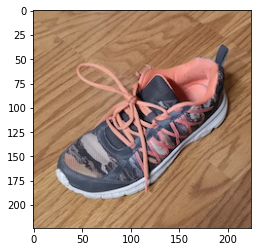

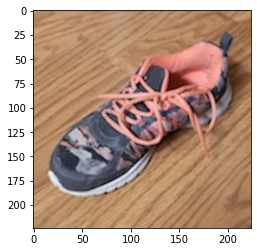

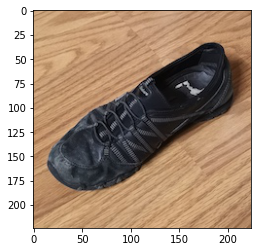

In [5]:
# Some visualizing
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:] + 0.5); # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:] + 0.5); # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:] + 0.5); # right shoe of second pair submitted by 5th student


Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

We will write a function `generate_same_pair()` that takes one of the data sets that we produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

<IPython.core.display.Javascript object>

(96, 3, 2, 224, 224, 3)
(288, 448, 224, 3)


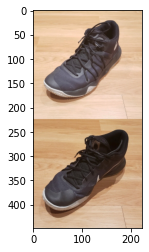

In [6]:
def generate_same_pair(data):
  """
  Takes a dataset of shape [*, 3, 2, 224, 224, 3] where:
  * - number of triplets of pairs of shoes in the dataset
  3 - the index of the image pair in the triplet of pairs
  2 - the left ([0]) or right ([1]) shoe in the image pair
  [224, 224, 3] - the dimensions of the RGB image
  and return a vertical concatenation of the image pairs in the dataset so
  the output shape is [3*, 448, 224, 3]
  """
  # instantiating the concatenated dataset
  con_data = np.empty([3*data.shape[0], 2*data.shape[3], data.shape[4], data.shape[5]])
  index = 0

  # Concatenating the image pairs
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      con_data[index, :224, :, :] = data[i, j, 0, :, :, :]
      con_data[index, 224:, :, :] = data[i, j, 1, :, :, :]
      index += 1

  return con_data


print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0] + 0.5); # should show 2 shoes from the same pair

We will write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

<IPython.core.display.Javascript object>

(96, 3, 2, 224, 224, 3)
(288, 448, 224, 3)


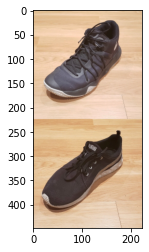

In [7]:
def generate_different_pair(data):
  """
  Takes a dataset of shape [*, 3, 2, 224, 224, 3] where:
  * - number of triplets of pairs of shoes in the dataset
  3 - the index of the image pair in the triplet of pairs
  2 - the left ([0]) or right ([1]) shoe in the image pair
  [224, 224, 3] - the dimensions of the RGB image
  and return a vertical concatenation of the image pairs of mismatched shoes 
  (shuffled within the same student submission). The output shape is [3*, 448, 224, 3]
  """
  # instantiating the concatenated dataset
  con_data = np.empty([3*data.shape[0], 2*data.shape[3], data.shape[4], data.shape[5]])
  index = 0
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      con_data[index, :224, :, :] = data[i, j, 0, :, :, :]
      con_data[index, 224:, :, :] = data[i, (j+1) % 3, 1, :, :, :]
      index += 1

  return con_data


print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0] + 0.5); # should show 2 shoes from different pairs

Why do we insist that the different pairs of shoes still come from the same
person?

Images taken by different people will have a unique image perspective to the shoes due to the unique height of each person along with different backgrounds. Due to this, if we dont shuffle pictures taken by the same person but rather shuffle randomly regardless of the person the model may learn to classify shoe mismatches soley based on differing picture angles and backgrounds regardless of the shoe characteristics.

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?


*If the data set is imbalanced we may accidently teach the model that it is preferable to classify one class over the other. Taking for example the case where a data set contains 99% of class A and the remaining 1% are class B. In this case the model will learn that always classifying the data as class A for any item in the data set will yield an accuracy of 99% and the model will never classify items belonging to class B.*

## 2. Convolutional Neural Networks 

In this section, we will build two CNN models in PyTorch.

We implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of our CNN. We can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set our padding to be `(kernel_size - 1) / 2` so that our feature maps
have an even height/width.

In [8]:
class CNN(nn.Module):
    def __init__(self, n=4, ker_size=5):
        super(CNN, self).__init__()
        self.n = n
        self.ker_size = ker_size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=ker_size, stride=1, padding=int((ker_size - 1)/2))
        self.batch_norm1 = nn.BatchNorm2d(num_features=n)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=ker_size, stride=1, padding=int((ker_size - 1)/2))
        self.batch_norm2 = nn.BatchNorm2d(num_features=2*n)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=ker_size, stride=1, padding=int((ker_size - 1)/2))
        self.batch_norm3 = nn.BatchNorm2d(num_features=4*n)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=ker_size, stride=1, padding=int((ker_size - 1)/2))
        self.batch_norm4 = nn.BatchNorm2d(num_features=8*n)
        self.fc1 = nn.Linear(in_features=3136*n, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=2)
        
    def forward(self, inp, verbose=False):
      x = self.conv1(inp)
      x = self.batch_norm1(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = self.conv2(x)
      #x = self.batch_norm2(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = self.conv3(x)
      #x = self.batch_norm3(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = self.conv4(x)
      #x = self.batch_norm4(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = x.reshape([-1, 3136*self.n])
      x = self.fc1(x)
      x = nn.functional.relu(x)
      x = self.fc2(x)
      return x

<IPython.core.display.Javascript object>

We implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as the previous CNN, but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


In [10]:
class CNNChannel(nn.Module):
    def __init__(self, n=4, ker_size=3):
        super(CNNChannel, self).__init__()
        self.n = n
        self.ker_size = ker_size
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, kernel_size=ker_size, stride=1, padding=int((ker_size - 1) / 2))
        self.batch_norm1 = nn.BatchNorm2d(num_features=n)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=ker_size, stride=1, padding=int((ker_size - 1) / 2))
        self.batch_norm2 = nn.BatchNorm2d(num_features=2*n)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=ker_size, stride=1, padding=int((ker_size - 1) / 2))
        self.batch_norm3 = nn.BatchNorm2d(num_features=4*n)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=ker_size, stride=1, padding=int((ker_size - 1) / 2))
        self.batch_norm4 = nn.BatchNorm2d(num_features=8*n)
        self.fc1 = nn.Linear(in_features=1568*n, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=2)
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, inp, verbose=False):
      #print(inp.shape)
      x = torch.cat((inp[:, :, :224, :], inp[:, :, 224:, :]), dim=1)
      x = self.conv1(x)
      x = self.batch_norm1(x)
      x = nn.functional.relu(x)
      x = self.dropout(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = self.conv2(x)
      #x = self.batch_norm2(x)
      x = nn.functional.relu(x)
      x = self.dropout(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = self.conv3(x)
      #x = self.batch_norm3(x)
      x = nn.functional.relu(x)
      x = self.dropout(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = self.conv4(x)
      #x = self.batch_norm4(x)
      x = nn.functional.relu(x)
      #x = self.dropout(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      #print(x.shape)
      x = x.reshape([-1, 1568*self.n])
      x = self.fc1(x)
      x = nn.functional.relu(x)
      x = self.fc2(x)
      return x

<IPython.core.display.Javascript object>

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning.


*At this point we can predict that the channel CNN will probably preform better than the side-by-side CNN. The reason behind this is that since the channel CNN has the two images as different channels, measurments similar to similarities or correlation and other such methods in order to ascertain whether the shoes match each other*

We may wish to track false positives and negatives seperately since they are two different phenomena and we may prefer to improve one over the other.  For example, we may prefer our model have a very low false positive rate at the expense of a high false negative rate so if the model classifies a pair of shoes as a match, so the shoes will most likely be a match, and if the model classifies the pair as a mismatch, it may or not be a match.

In [11]:
def get_accuracy(model, data, batch_size=50):
    """
    Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0, 3, 1, 2)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0, 3, 1, 2)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

<IPython.core.display.Javascript object>

## 3. Training 

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target. We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for us to generate separate minibatches of positive and negative training data.
 In each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what our training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch.

In [12]:
def get_batch(data, min, max, is_pos):
  """
  data - Is the data from which we're taking our batch
  min - index of the starting point of the batch
  max - index of the end point of the batch
  is_neg - Boolean, whether or not the data is a matching pair of shoes.
  """

  batch = data[min:max, :, :, :]

  if is_pos:
    labels = np.ones(shape=(max-min))
  elif not is_pos:
    labels = np.zeros(shape=(max-min))
  else:
    raise Exception('is_pos must be a boolean')
  
  return batch, labels

<IPython.core.display.Javascript object>

In [13]:
def train_model(model,
                train_data=train_data,
                valid_data=valid_data,
                batch_size=30,
                max_iters=1000,
                learning_rate=0.001,
                weight_decay=0,
                checkpoint_path=None,
                print_freq=50):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(lr=learning_rate,
                         params=model.parameters(),
                         weight_decay=weight_decay)
  
  # Counting the number of iterations n
  n = 0
  train_pos = generate_same_pair(train_data)
  train_neg = generate_different_pair(train_data)
  iters, losses = [], []
  iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs  = [], [] ,[], [], []

  while True:
    shuffled_indices = np.random.permutation(train_pos.shape[0])
    train_pos = train_pos[shuffled_indices]
    train_neg = train_neg[shuffled_indices]

    for i in range(0, train_pos.shape[0], int(batch_size / 2)):
      # Breaking the loop if i will exceed the index of the training data
      if i + (batch_size / 2) > train_pos.shape[0]:
        break

    model.train()
    # Getting the batch of positive and negative data  
    xt_pos, st_pos = get_batch(train_pos, min=i, max=i + int(batch_size / 2), is_pos=True)
    xt_neg, st_neg = get_batch(train_neg, min=i, max=i + int(batch_size / 2), is_pos=False)

    # Concatenating and shuffling the data together
    xt = np.concatenate((xt_pos, xt_neg), axis=0)
    st = np.concatenate((st_pos, st_neg), axis=0)
    shuffled_indices = np.random.permutation(xt.shape[0])
    xt = xt[shuffled_indices]
    st = st[shuffled_indices]

    # Converting the batch into a pytorch tensor with a shape of (N×C×H×W)
    xt = torch.Tensor(xt).permute(0, 3, 1, 2) #Changing (NxHxWxC) into (NxCxHxW)
    st = torch.Tensor(st).long()

    zs = model(xt)
    loss = criterion(zs, st)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    iters.append(n)
    losses.append(float(loss)/int(batch_size/2))  # compute *average* loss

    if n % print_freq == 0:
      iters_sub.append(n)
      train_cost = float(loss.detach().numpy())
      train_pos_acc, train_neg_acc = get_accuracy(model, train_data)
      train_pos_accs.append(train_pos_acc)
      train_neg_accs.append(train_neg_acc)
      val_pos_acc, val_neg_acc = get_accuracy(model, valid_data)
      val_pos_accs.append(val_pos_acc)
      val_neg_accs.append(val_neg_acc)
      print("Iter %d. [Val Pos Acc %.0f%%] [Val Neg Acc %.0f%%] [Train Pos Acc %.0f%%, Train Neg Acc %.0f%%, Loss %f]" % (
            n, val_pos_acc * 100, val_neg_acc * 100, train_pos_acc * 100, train_neg_acc * 100, train_cost))

      if (checkpoint_path is not None) and n > 0:
          torch.save(model.state_dict(), checkpoint_path.format(n))

    n += 1

    if n > max_iters:
        return iters, losses, iters_sub, val_pos_accs, val_neg_accs, train_pos_accs, train_neg_accs      
    

<IPython.core.display.Javascript object>

In [14]:
def plot_learning_curve(iters, losses, iters_sub, val_pos_accs, val_neg_accs, train_pos_accs, train_neg_accs, fig_size=(30,7)):
  """
  Takes the output from train_model() and plots the learning curves
  """
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=fig_size)
  ax[0].plot(iters, losses, label='Train')
  ax[0].set_xlabel('Iterations')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Learning Curve: Loss per Iteration')
  ax[0].legend(loc='upper right')

  ax[1].plot(iters_sub, train_pos_accs, label="Train")
  ax[1].plot(iters_sub, val_pos_accs, label="Validation")
  ax[1].set_xlabel('Iterations')
  ax[1].set_ylabel('Training Accuracy')
  ax[1].set_title('Learning Curve: Accuracy per Iteration for Matching Shoes')
  ax[1].legend(loc='upper right')

  ax[2].plot(iters_sub, train_neg_accs, label="Train")
  ax[2].plot(iters_sub, val_neg_accs, label="Validation")
  ax[2].set_xlabel('Iterations')
  ax[2].set_ylabel('Training Accuracy')
  ax[2].set_title('Learning Curve: Accuracy per Iteration for Mismatching Shoes')
  ax[2].legend(loc='upper right')

<IPython.core.display.Javascript object>


Sanity check with a small set of data to see that our model can memorize

Iter 0. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%, Train Neg Acc 100%, Loss 0.693710]
Iter 5. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%, Train Neg Acc 100%, Loss 0.693166]
Iter 10. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%, Train Neg Acc 100%, Loss 0.687074]
Iter 15. [Val Pos Acc 77%] [Val Neg Acc 67%] [Train Pos Acc 100%, Train Neg Acc 83%, Loss 0.621554]
Iter 20. [Val Pos Acc 77%] [Val Neg Acc 65%] [Train Pos Acc 100%, Train Neg Acc 83%, Loss 0.311898]
Iter 25. [Val Pos Acc 67%] [Val Neg Acc 71%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.027068]
Iter 30. [Val Pos Acc 69%] [Val Neg Acc 71%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.000669]
Iter 35. [Val Pos Acc 67%] [Val Neg Acc 71%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.000026]
Iter 40. [Val Pos Acc 62%] [Val Neg Acc 71%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.000000]
Iter 45. [Val Pos Acc 58%] [Val Neg Acc 73%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.000000]


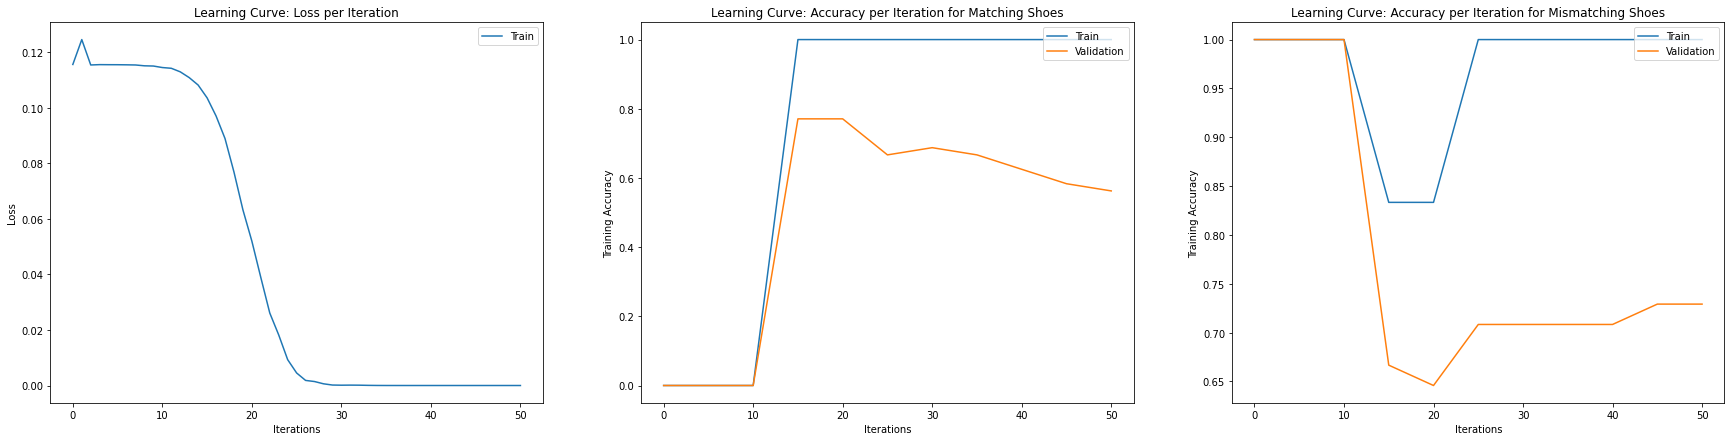

In [ ]:
channel_cnn = CNNChannel()
learning_curve_info = train_model(channel_cnn,
                                  train_data=train_data[:2, :, :, :, :, :],
                                  learning_rate=0.003,
                                  batch_size=12,
                                  max_iters=50,
                                  weight_decay=0,
                                  print_freq=5)

plot_learning_curve(*learning_curve_info)

#### Hyperparameter tuning - Channel CNN
- learning rate = 0.003, batch_size=4, max_iters=100 - **memorizes after 50 iters**
- learning rate = 0.003, batch_size=12, max_iters=100 - **memorizes after 25 iters**

Iter 0. [Val Pos Acc 100%] [Val Neg Acc 0%] [Train Pos Acc 100%, Train Neg Acc 0%, Loss 0.694191]
Iter 5. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%, Train Neg Acc 100%, Loss 0.693535]
Iter 10. [Val Pos Acc 100%] [Val Neg Acc 0%] [Train Pos Acc 100%, Train Neg Acc 0%, Loss 0.693090]
Iter 15. [Val Pos Acc 25%] [Val Neg Acc 71%] [Train Pos Acc 67%, Train Neg Acc 50%, Loss 0.691706]
Iter 20. [Val Pos Acc 33%] [Val Neg Acc 71%] [Train Pos Acc 50%, Train Neg Acc 83%, Loss 0.683825]
Iter 25. [Val Pos Acc 73%] [Val Neg Acc 31%] [Train Pos Acc 83%, Train Neg Acc 83%, Loss 0.628064]
Iter 30. [Val Pos Acc 77%] [Val Neg Acc 27%] [Train Pos Acc 100%, Train Neg Acc 50%, Loss 0.438011]
Iter 35. [Val Pos Acc 67%] [Val Neg Acc 46%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.225099]
Iter 40. [Val Pos Acc 73%] [Val Neg Acc 27%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.060287]
Iter 45. [Val Pos Acc 71%] [Val Neg Acc 31%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.007991]
Iter 

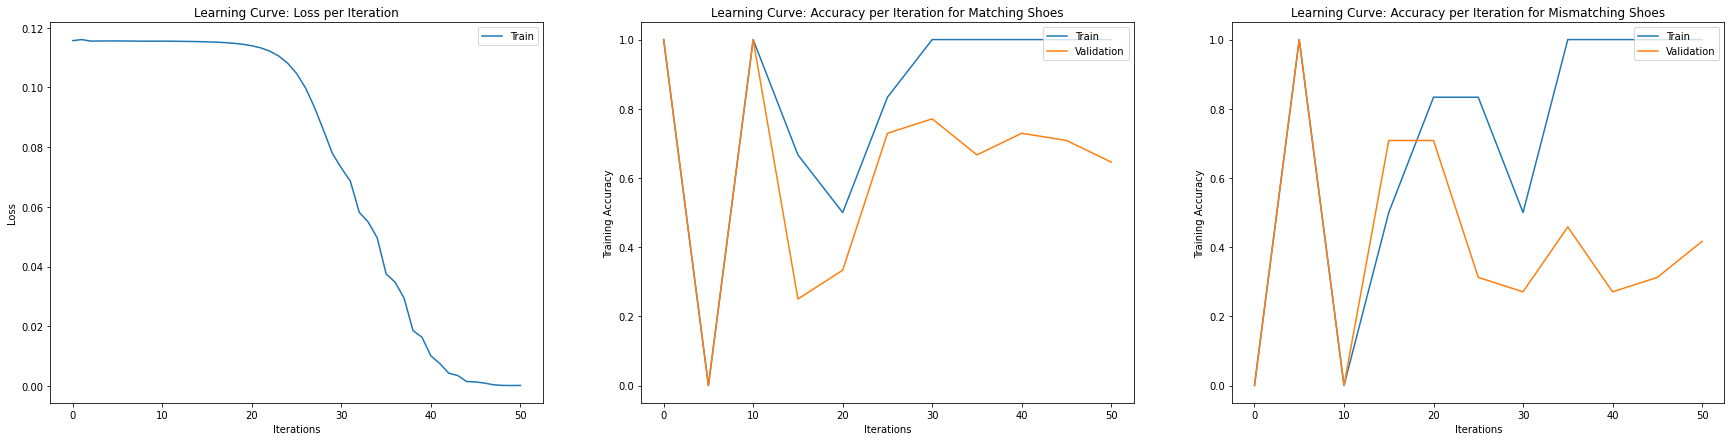

In [ ]:
cnn = CNN()
learning_curve_info = train_model(cnn,
                                  train_data=train_data[:2, :, :, :, :, :],
                                  learning_rate=0.001,
                                  batch_size=12,
                                  max_iters=50,
                                  weight_decay=0,
                                  print_freq=5)

plot_learning_curve(*learning_curve_info)

#### Hyperparameter tuning - CNN
- learning rate = 0.001, batch_size=12, max_iters=200 - **memorizes after 35 iters**


For the hyperparameter tuning we'll use the baseline parameters used to overfit the models in the previous section, and create 4 lists with learning rate, batch size and kernal size variations. using these lists we'll plot the learning curves for each of these combinations and see which combination behaves the best

#### CNN hyperparameter tuning
Using the hyperparameters obtained in the previous section we receive the following preformance:
- baseline hyperparameters - learning_rate=0.001, batch_size=32, max_iters=500 - [Val Pos Acc 85%] [Val Neg Acc 69%] [Train Pos Acc 95%, Train Neg Acc 92%]

Training CNN model with a learning rate of 0.001, batch size of 16 and kernal size of 5...
Iter 0. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%, Train Neg Acc 100%, Loss 0.696536]
Iter 25. [Val Pos Acc 6%] [Val Neg Acc 98%] [Train Pos Acc 14%, Train Neg Acc 88%, Loss 0.692803]
Iter 50. [Val Pos Acc 15%] [Val Neg Acc 94%] [Train Pos Acc 19%, Train Neg Acc 84%, Loss 0.693624]
Iter 75. [Val Pos Acc 56%] [Val Neg Acc 75%] [Train Pos Acc 58%, Train Neg Acc 53%, Loss 0.691728]
Iter 100. [Val Pos Acc 94%] [Val Neg Acc 27%] [Train Pos Acc 81%, Train Neg Acc 38%, Loss 0.700181]
Iter 125. [Val Pos Acc 19%] [Val Neg Acc 96%] [Train Pos Acc 30%, Train Neg Acc 85%, Loss 0.631072]
Iter 150. [Val Pos Acc 90%] [Val Neg Acc 54%] [Train Pos Acc 92%, Train Neg Acc 47%, Loss 0.494048]
Iter 175. [Val Pos Acc 75%] [Val Neg Acc 58%] [Train Pos Acc 76%, Train Neg Acc 67%, Loss 0.576171]
Iter 200. [Val Pos Acc 92%] [Val Neg Acc 56%] [Train Pos Acc 88%, Train Neg Acc 63%, Loss 0.588650]
The learning cu

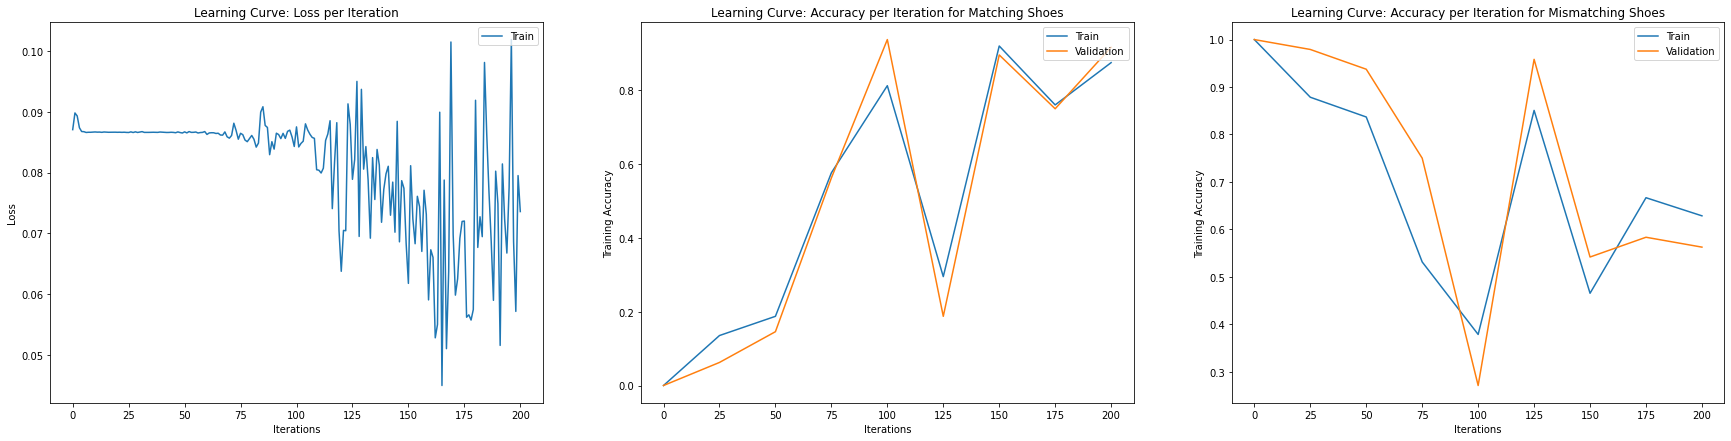

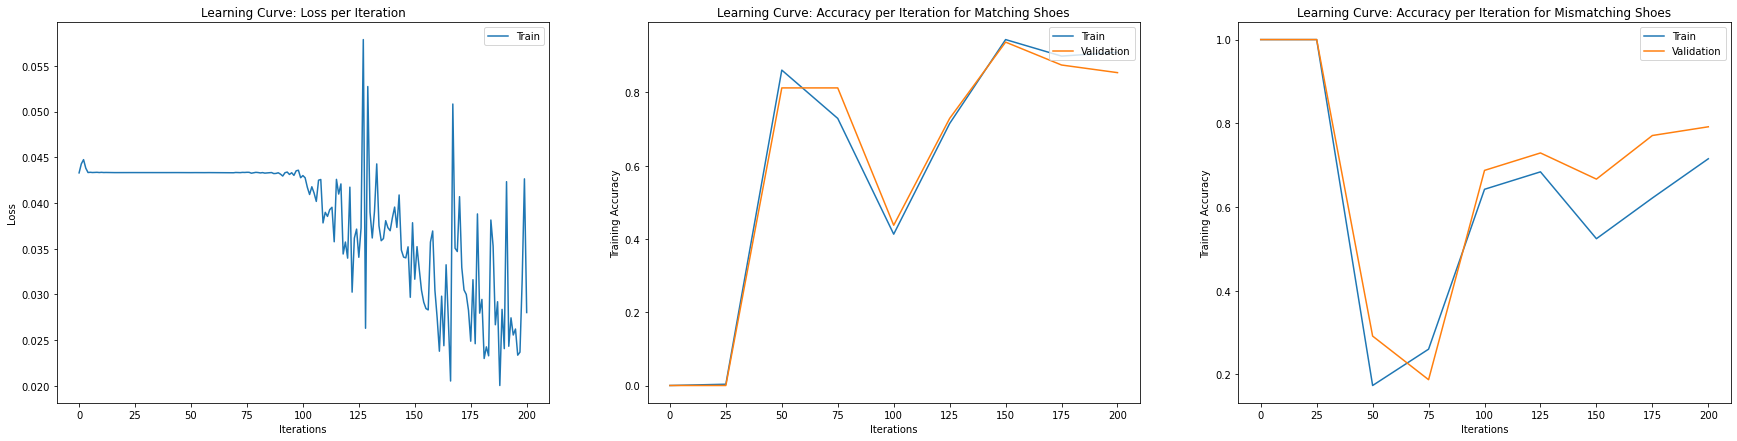

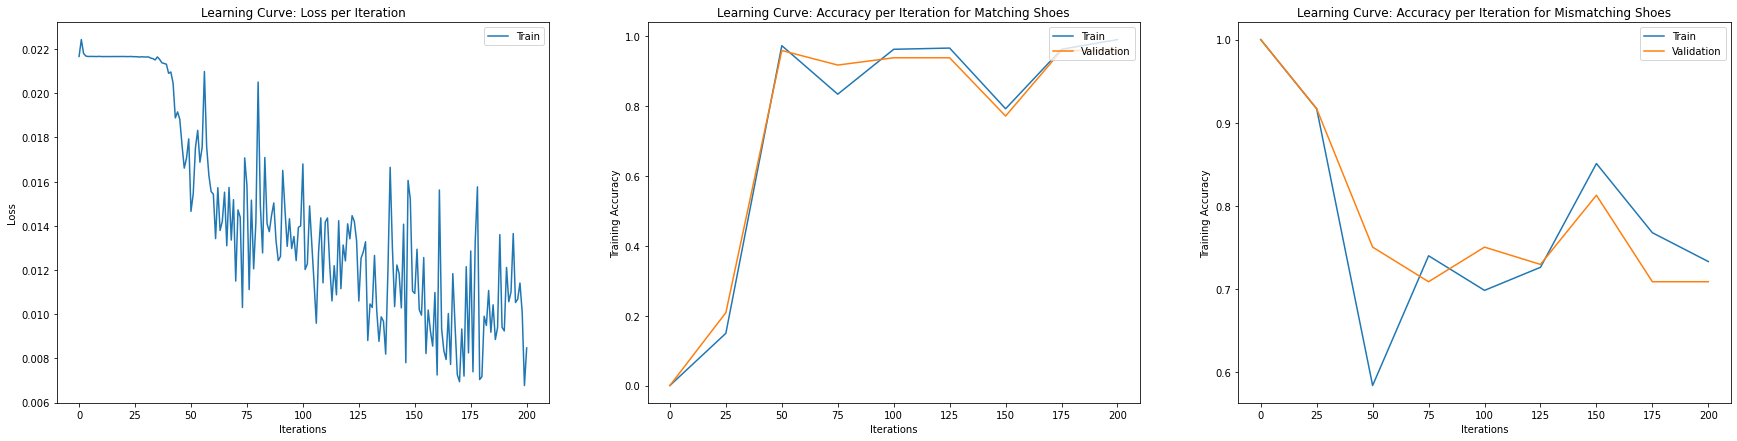

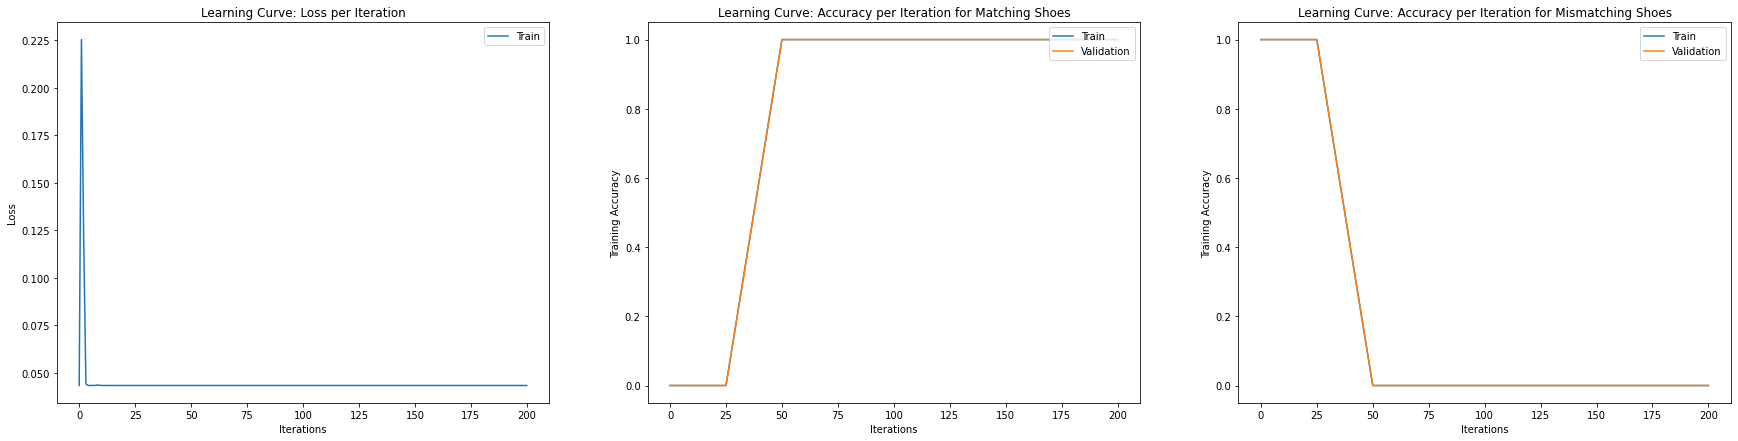

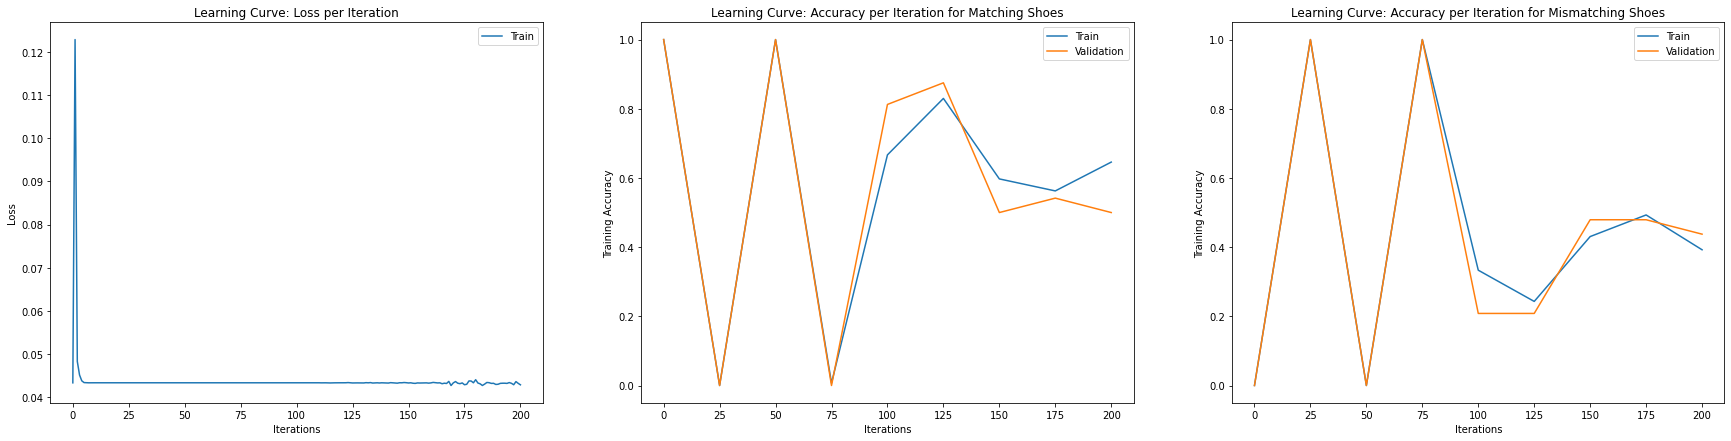

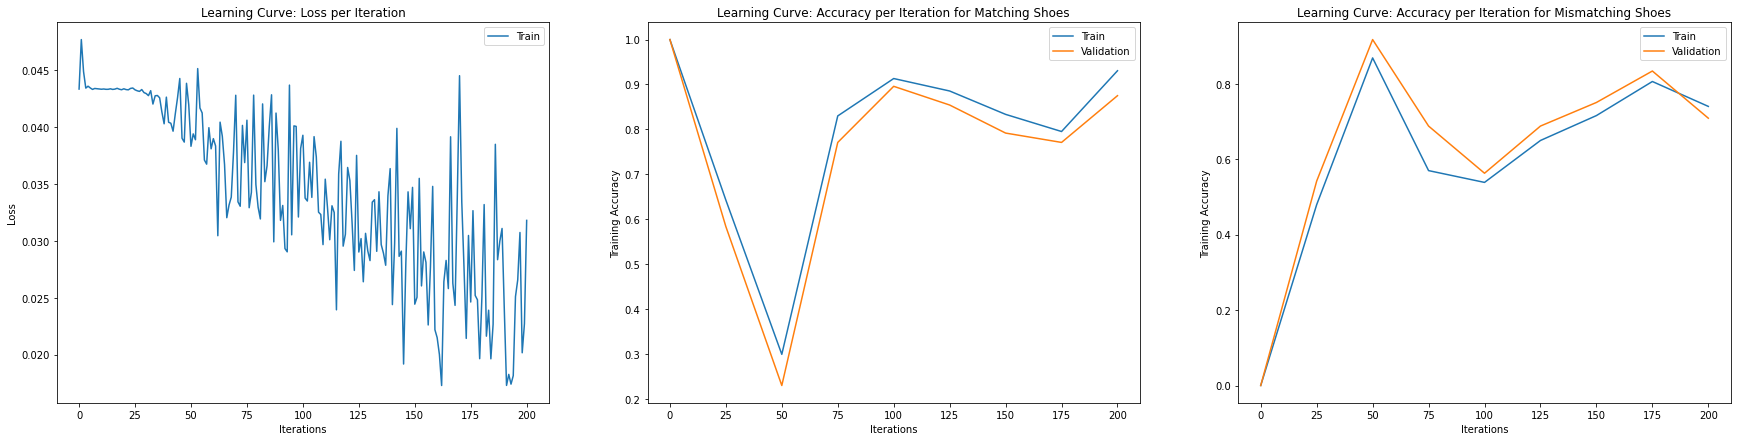

In [ ]:

learn_rate = [0.001, 0.001, 0.001, 0.01, 0.003, 0.003]
batch_size = [16, 32, 64, 32, 32, 32]
ker_size = [5, 5, 5, 3, 5, 7] 

for i in range(len(ker_size)):
  cnn = CNN(ker_size=ker_size[i])
  print(f'Training CNN model with a learning rate of {learn_rate[i]}, batch size of {batch_size[i]} and kernal size of {ker_size[i]}...')
  learning_curve_info = train_model(cnn,
                                    train_data=train_data,
                                    valid_data=valid_data,
                                    learning_rate=learn_rate[i],
                                    batch_size=batch_size[i],
                                    max_iters=200,
                                    weight_decay=0,
                                    print_freq=25)

  print(f'The learning curves for the CNN model with a learning rate of {learn_rate[i]}, batch size of {batch_size[i]} and kernal size of {ker_size[i]}:')
  plot_learning_curve(*learning_curve_info, fig_size=(25,5))

We see that for the hyperparameters: `learning_rate=0.001, batch_size=64, kernel_size=5` we recieve the fastest convergence for the regular CNN model.

#### Channel CNN hyperparameter tuning
Using the hyperparameters obtained in the previous section we receive the following preformance which we will use as a benchmark:

<IPython.core.display.Javascript object>

Iter 0. [Val Pos Acc 100%] [Val Neg Acc 0%] [Train Pos Acc 100%, Train Neg Acc 0%, Loss 0.695018]
Iter 50. [Val Pos Acc 90%] [Val Neg Acc 69%] [Train Pos Acc 96%, Train Neg Acc 64%, Loss 0.292476]
Iter 100. [Val Pos Acc 83%] [Val Neg Acc 83%] [Train Pos Acc 94%, Train Neg Acc 82%, Loss 0.308378]
Iter 150. [Val Pos Acc 73%] [Val Neg Acc 90%] [Train Pos Acc 90%, Train Neg Acc 95%, Loss 0.234017]
Iter 200. [Val Pos Acc 71%] [Val Neg Acc 85%] [Train Pos Acc 94%, Train Neg Acc 98%, Loss 0.103755]
Iter 250. [Val Pos Acc 81%] [Val Neg Acc 81%] [Train Pos Acc 98%, Train Neg Acc 95%, Loss 0.064234]
Iter 300. [Val Pos Acc 73%] [Val Neg Acc 83%] [Train Pos Acc 99%, Train Neg Acc 100%, Loss 0.008330]
Iter 350. [Val Pos Acc 73%] [Val Neg Acc 85%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.001304]
Iter 400. [Val Pos Acc 73%] [Val Neg Acc 85%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.011862]
Iter 450. [Val Pos Acc 73%] [Val Neg Acc 85%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.0006

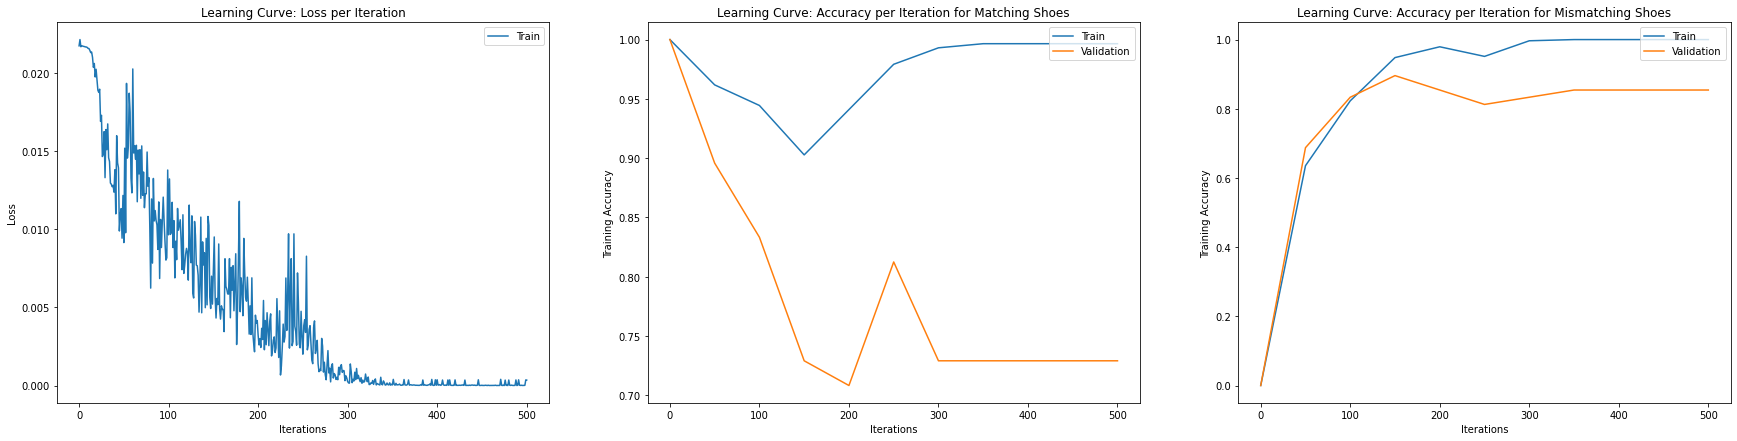

In [ ]:
channel_cnn = CNNChannel()
learning_curve_info = train_model(channel_cnn,
                                  train_data=train_data,
                                  valid_data=valid_data,
                                  learning_rate=0.003,
                                  batch_size=64,
                                  max_iters=500,
                                  weight_decay=0,
                                  print_freq=50)

plot_learning_curve(*learning_curve_info)

<IPython.core.display.Javascript object>

Training Channel CNN model with a learning rate of 0.003, batch size of 16 and kernal size of 5...
Iter 0. [Val Pos Acc 79%] [Val Neg Acc 21%] [Train Pos Acc 86%, Train Neg Acc 18%, Loss 0.693165]
Iter 50. [Val Pos Acc 92%] [Val Neg Acc 46%] [Train Pos Acc 94%, Train Neg Acc 39%, Loss 0.620020]
Iter 100. [Val Pos Acc 90%] [Val Neg Acc 58%] [Train Pos Acc 88%, Train Neg Acc 52%, Loss 0.536218]
Iter 150. [Val Pos Acc 77%] [Val Neg Acc 54%] [Train Pos Acc 91%, Train Neg Acc 45%, Loss 0.632832]
Iter 200. [Val Pos Acc 85%] [Val Neg Acc 62%] [Train Pos Acc 89%, Train Neg Acc 54%, Loss 0.536738]
Iter 250. [Val Pos Acc 79%] [Val Neg Acc 65%] [Train Pos Acc 87%, Train Neg Acc 60%, Loss 0.643916]
Iter 300. [Val Pos Acc 85%] [Val Neg Acc 62%] [Train Pos Acc 92%, Train Neg Acc 61%, Loss 0.290349]
Iter 350. [Val Pos Acc 65%] [Val Neg Acc 73%] [Train Pos Acc 84%, Train Neg Acc 78%, Loss 0.603703]
Iter 400. [Val Pos Acc 77%] [Val Neg Acc 62%] [Train Pos Acc 85%, Train Neg Acc 69%, Loss 0.325126]
Iter

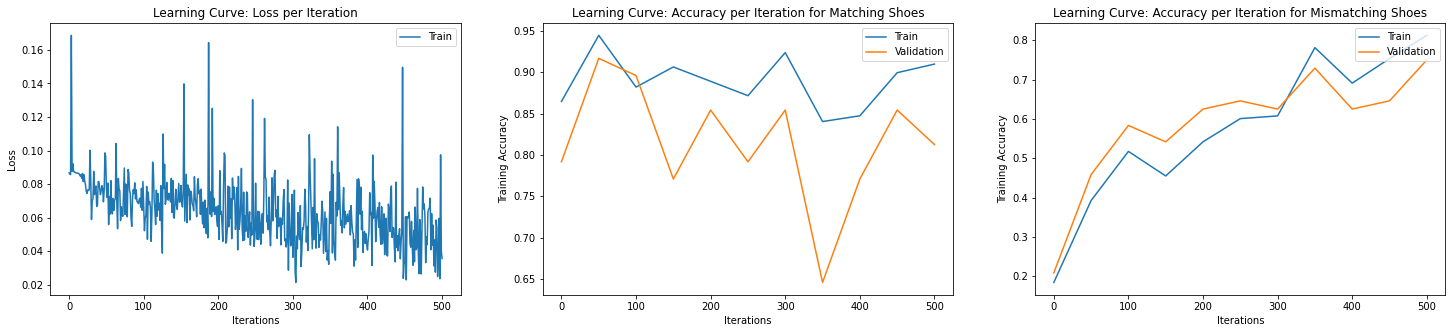

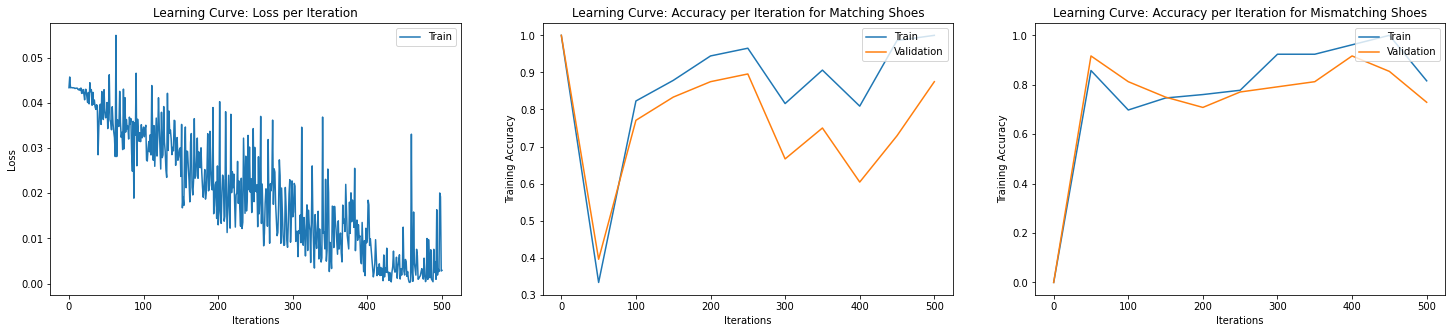

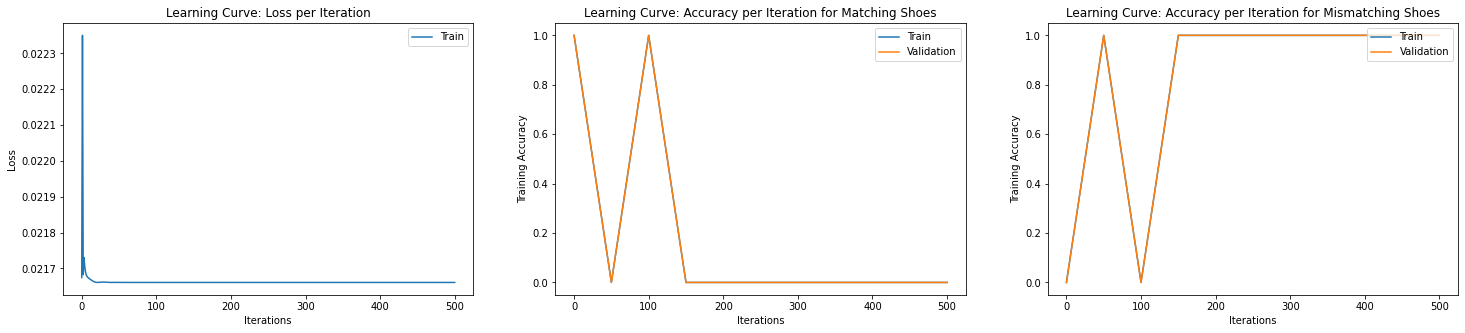

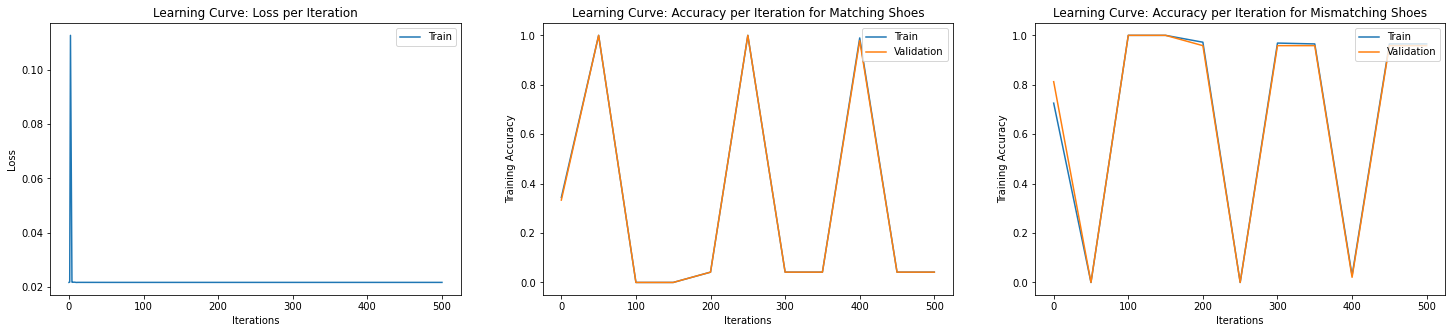

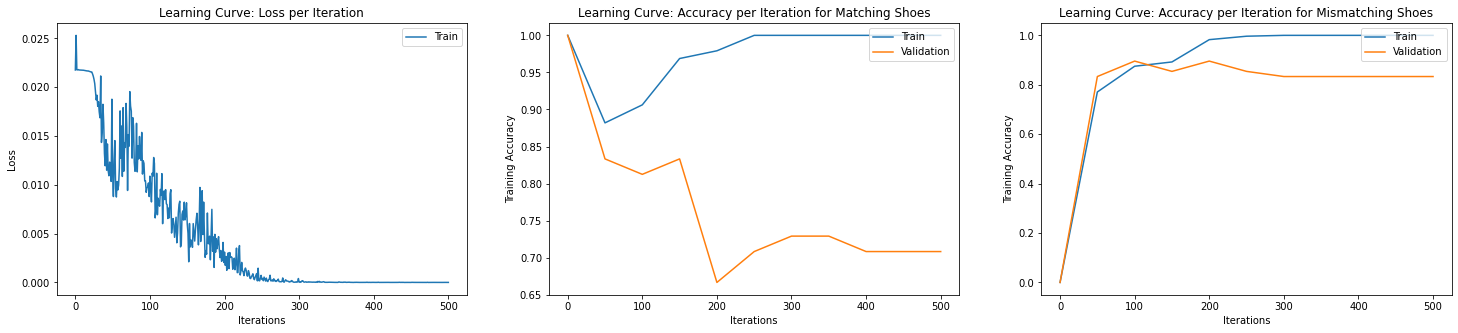

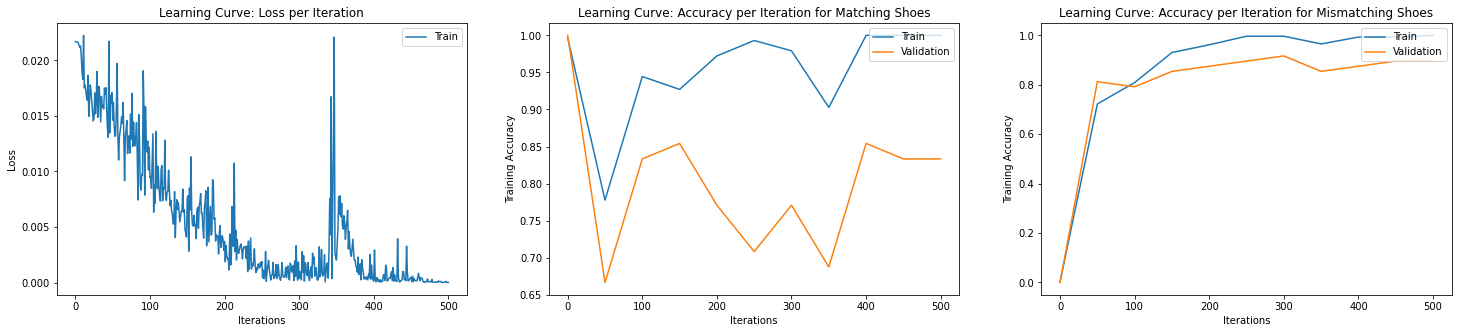

In [ ]:
learn_rate = [0.003, 0.003, 0.003, 0.01, 0.003, 0.001, 0.003]
batch_size = [16, 32, 64, 64, 64, 64]
ker_size = [5, 5, 5, 5, 3, 7] 

for i in range(len(ker_size)):
  channel_cnn = CNNChannel(ker_size=ker_size[i])
  print(f'Training Channel CNN model with a learning rate of {learn_rate[i]}, batch size of {batch_size[i]} and kernal size of {ker_size[i]}...')
  learning_curve_info = train_model(channel_cnn,
                                    train_data=train_data,
                                    valid_data=valid_data,
                                    learning_rate=learn_rate[i],
                                    batch_size=batch_size[i],
                                    max_iters=500,
                                    weight_decay=0,
                                    print_freq=50)

  print(f'The learning curves for the Channel CNN model with a learning rate of {learn_rate[i]}, batch size of {batch_size[i]} and kernal size of {ker_size[i]}:')
  plot_learning_curve(*learning_curve_info, fig_size=(25,5))

We see that we got the best validation accuracies for the hyperparameters - learning rate = 0.001, batch size = 64 and kernal size = 7.

Since we didn't seperate the change in kernel size and change in learning rate, We now want to check which of the hyperparameters caused the increase in preformance.


<IPython.core.display.Javascript object>

Training Channel CNN model with a learning rate of 0.001, batch size of 64 and kernal size of 3...
Iter 0. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%, Train Neg Acc 100%, Loss 0.693115]
Iter 50. [Val Pos Acc 69%] [Val Neg Acc 58%] [Train Pos Acc 58%, Train Neg Acc 72%, Loss 0.658593]
Iter 100. [Val Pos Acc 71%] [Val Neg Acc 56%] [Train Pos Acc 68%, Train Neg Acc 63%, Loss 0.670235]
Iter 150. [Val Pos Acc 71%] [Val Neg Acc 60%] [Train Pos Acc 69%, Train Neg Acc 70%, Loss 0.599717]
Iter 200. [Val Pos Acc 75%] [Val Neg Acc 52%] [Train Pos Acc 70%, Train Neg Acc 72%, Loss 0.501693]
Iter 250. [Val Pos Acc 58%] [Val Neg Acc 67%] [Train Pos Acc 51%, Train Neg Acc 88%, Loss 0.484971]
Iter 300. [Val Pos Acc 77%] [Val Neg Acc 52%] [Train Pos Acc 83%, Train Neg Acc 74%, Loss 0.374030]
Iter 350. [Val Pos Acc 75%] [Val Neg Acc 46%] [Train Pos Acc 91%, Train Neg Acc 82%, Loss 0.377699]
Iter 400. [Val Pos Acc 65%] [Val Neg Acc 60%] [Train Pos Acc 76%, Train Neg Acc 97%, Loss 0.235611]
Iter

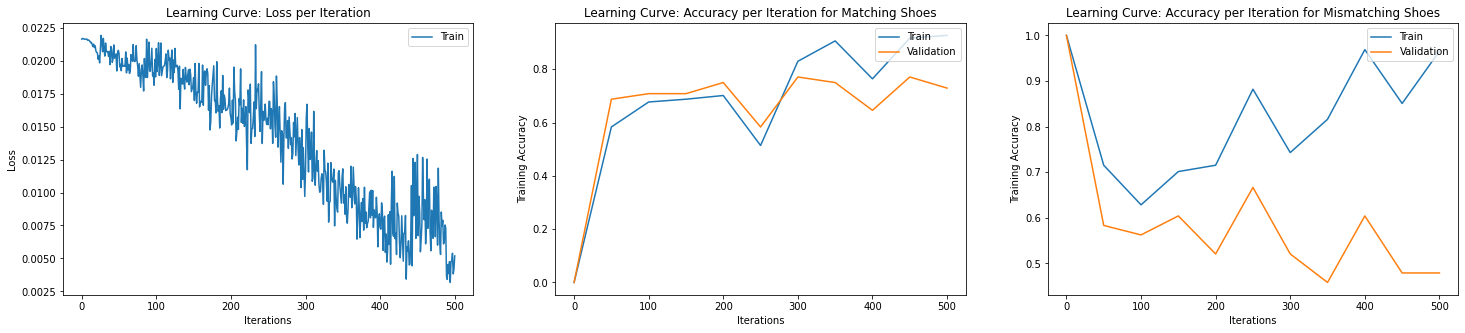

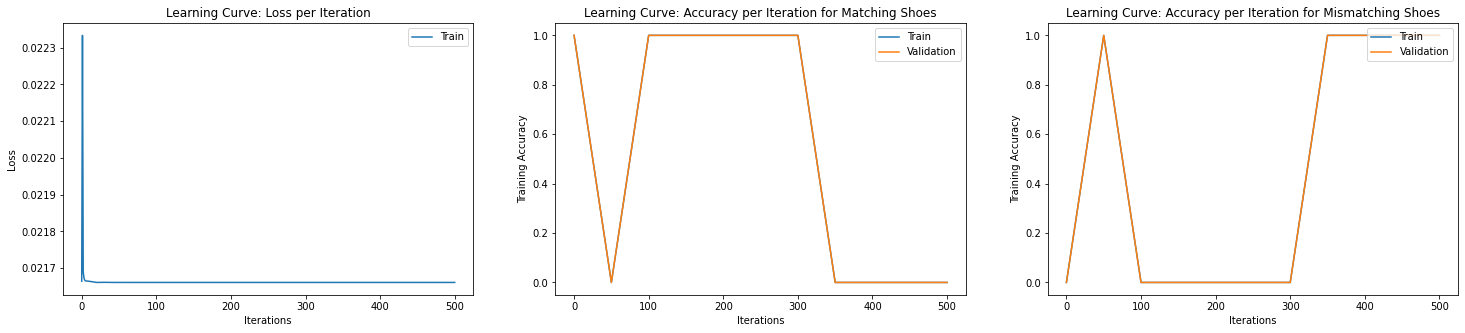

In [ ]:
learn_rate = [0.001, 0.003]
batch_size = [64, 64]
ker_size = [3, 7] 

for i in range(len(ker_size)):
  channel_cnn = CNNChannel(ker_size=ker_size[i])
  print(f'Training Channel CNN model with a learning rate of {learn_rate[i]}, batch size of {batch_size[i]} and kernal size of {ker_size[i]}...')
  learning_curve_info = train_model(channel_cnn,
                                    train_data=train_data,
                                    valid_data=valid_data,
                                    learning_rate=learn_rate[i],
                                    batch_size=batch_size[i],
                                    max_iters=500,
                                    weight_decay=0,
                                    print_freq=50,
                                    checkpoint_path='/content/gdrive/MyDrive/Intro to Deep Learning/Assignment 3/Checkpoints/ckpt-{}.pk')

  print(f'The learning curves for the Channel CNN model with a learning rate of {learn_rate[i]}, batch size of {batch_size[i]} and kernal size of {ker_size[i]}:')
  plot_learning_curve(*learning_curve_info, fig_size=(25,5))

From here we see that the seperate change of hyperparameters didnt have as great a change in the model preformance so we'll stay with `learning rate = 0.001, batch size = 64 and kernal size = 7` as the ideal hyperparameters

The training curves for our best models

<IPython.core.display.Javascript object>

-------------------------------------------------------- CNN ---------------------------------------------------------
Iter 0. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%, Train Neg Acc 100%, Loss 0.693550]
Iter 100. [Val Pos Acc 54%] [Val Neg Acc 60%] [Train Pos Acc 52%, Train Neg Acc 59%, Loss 0.650746]
Iter 200. [Val Pos Acc 81%] [Val Neg Acc 67%] [Train Pos Acc 89%, Train Neg Acc 94%, Loss 0.181826]
Iter 300. [Val Pos Acc 85%] [Val Neg Acc 60%] [Train Pos Acc 98%, Train Neg Acc 97%, Loss 0.135304]
Iter 400. [Val Pos Acc 85%] [Val Neg Acc 58%] [Train Pos Acc 100%, Train Neg Acc 99%, Loss 0.007816]
Iter 500. [Val Pos Acc 85%] [Val Neg Acc 65%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.000670]
Iter 600. [Val Pos Acc 85%] [Val Neg Acc 67%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.002775]
Iter 700. [Val Pos Acc 88%] [Val Neg Acc 65%] [Train Pos Acc 100%, Train Neg Acc 97%, Loss 0.013545]
Iter 800. [Val Pos Acc 85%] [Val Neg Acc 65%] [Train Pos Acc 100%, Train Neg 

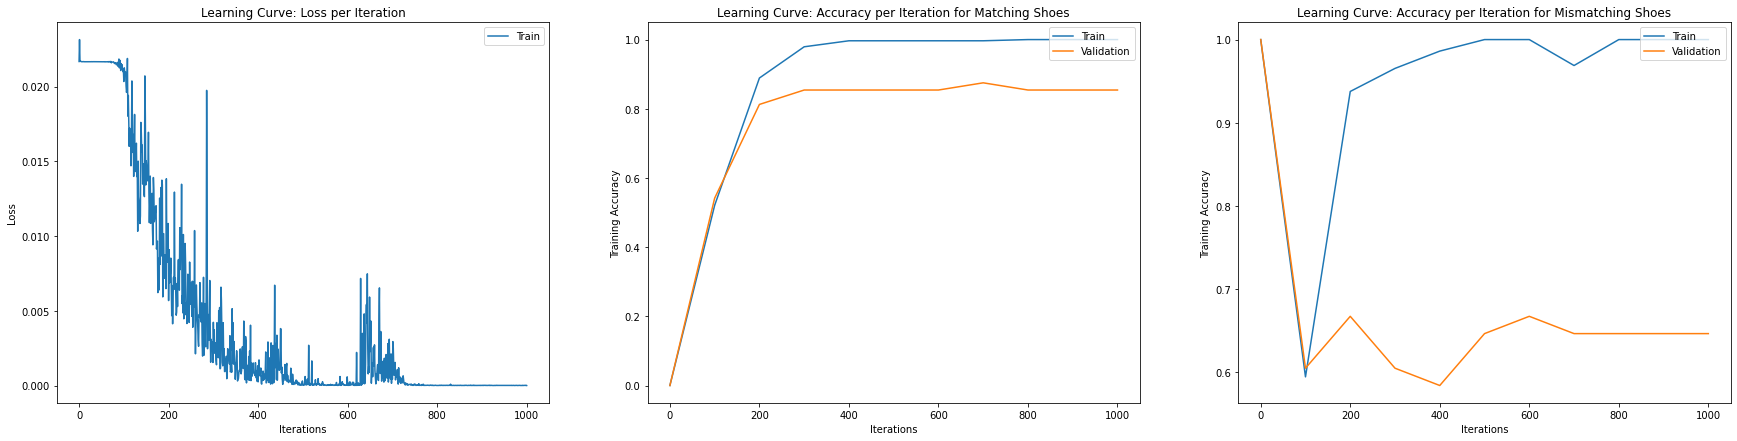

In [ ]:
print('-------------------------------------------------------- CNN ---------------------------------------------------------')
cnn = CNN(ker_size=5)
learning_curve_info = train_model(cnn,
                                  train_data=train_data,
                                  valid_data=valid_data,
                                  learning_rate=0.001,
                                  batch_size=64,
                                  max_iters=1000,
                                  weight_decay=0.0001,
                                  checkpoint_path='/content/gdrive/MyDrive/Intro to Deep Learning/Assignment 3/Checkpoints/CNN/ckpt-{}',
                                  print_freq=100)

plot_learning_curve(*learning_curve_info)

<IPython.core.display.Javascript object>

-------------------------------------------------Channel CNN ---------------------------------------------------------
Iter 0. [Val Pos Acc 0%] [Val Neg Acc 100%] [Train Pos Acc 0%, Train Neg Acc 100%, Loss 0.693212]
Iter 100. [Val Pos Acc 75%] [Val Neg Acc 90%] [Train Pos Acc 86%, Train Neg Acc 89%, Loss 0.271381]
Iter 200. [Val Pos Acc 73%] [Val Neg Acc 94%] [Train Pos Acc 93%, Train Neg Acc 97%, Loss 0.186740]
Iter 300. [Val Pos Acc 94%] [Val Neg Acc 71%] [Train Pos Acc 100%, Train Neg Acc 92%, Loss 0.092599]
Iter 400. [Val Pos Acc 83%] [Val Neg Acc 90%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.000894]
Iter 500. [Val Pos Acc 85%] [Val Neg Acc 88%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.000304]
Iter 600. [Val Pos Acc 85%] [Val Neg Acc 88%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.000190]
Iter 700. [Val Pos Acc 85%] [Val Neg Acc 88%] [Train Pos Acc 100%, Train Neg Acc 100%, Loss 0.000105]
Iter 800. [Val Pos Acc 85%] [Val Neg Acc 88%] [Train Pos Acc 100%, Train N

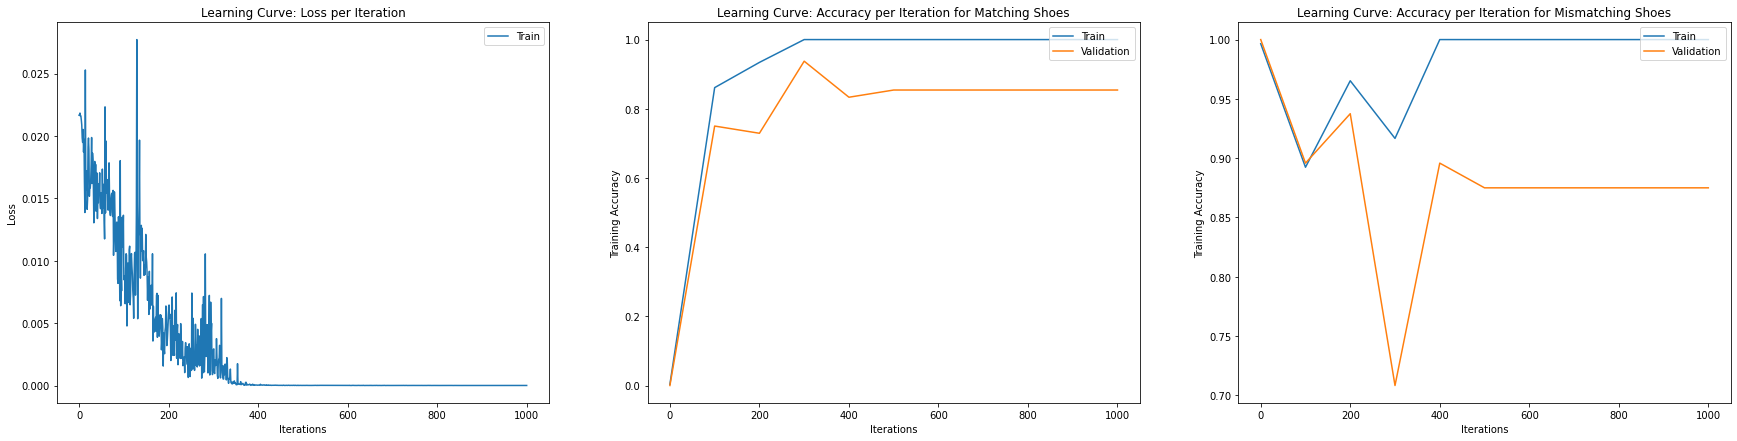

In [ ]:
print('-------------------------------------------------Channel CNN ---------------------------------------------------------')
channel_cnn = CNNChannel(ker_size=7)
learning_curve_info = train_model(channel_cnn,
                                  train_data=train_data,
                                  valid_data=valid_data,
                                  learning_rate=0.001,
                                  batch_size=64,
                                  max_iters=1000,
                                  weight_decay=0.0001,
                                  checkpoint_path='/content/gdrive/MyDrive/Intro to Deep Learning/Assignment 3/Checkpoints/Channel CNN/ckpt-{}',
                                  print_freq=100)

plot_learning_curve(*learning_curve_info)

We see that after 1000 iterations we got excellent preformance from the channel CNN model and so, we'll use the model from that iteration for the next questions.

## 4. Testing (15%)


In [25]:
# Since our best model was the Channel CNN, we'll use it for this section
channel_cnn = CNNChannel(ker_size=7)
channel_cnn.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro to Deep Learning/Assignment 3/Checkpoints/Channel CNN/ckpt-1000.pk'))

valid_pos_acc, valid_neg_acc = get_accuracy(channel_cnn, valid_data, batch_size=64)
test_m_pos_acc, test_m_neg_acc = get_accuracy(channel_cnn, test_m_data, batch_size=64)
test_w_pos_acc, test_w_neg_acc = get_accuracy(channel_cnn, test_w_data, batch_size=64)

print(f'[Val Pos Acc {round(valid_pos_acc*100)}%] [Val Neg Acc {round(valid_neg_acc*100)}%] [Test m Pos Acc {round(test_m_pos_acc*100)}%] [Test m Neg Acc {round(test_m_neg_acc*100)}%] [Test w Pos Acc {round(test_w_pos_acc*100)}%] [Test w Neg Acc {round(test_w_neg_acc*100)}%]')


<IPython.core.display.Javascript object>

[Val Pos Acc 92%] [Val Neg Acc 90%] [Test m Pos Acc 73%] [Test m Neg Acc 73%] [Test w Pos Acc 93%] [Test w Neg Acc 87%]


<IPython.core.display.Javascript object>

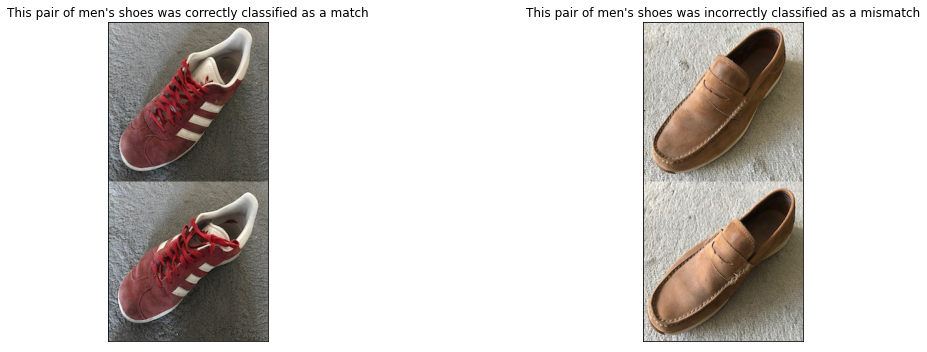

In [35]:
test_mens_same = generate_same_pair(test_m_data)
preds = np.argmax(channel_cnn(torch.Tensor(test_mens_same).permute(0, 3, 1, 2)).detach().numpy(), axis=1)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
fig.tight_layout(pad=1.0)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

for i in range(len(preds)):
  correct = 0
  incorrect = 0

  if preds[i] == 0 and incorrect == 0:
    #print('This pair of men\'s shoes was incorrectly classified as a mismatch')
    ax[1].imshow(test_mens_same[i] + 0.5)
    ax[1].set_title('This pair of men\'s shoes was incorrectly classified as a mismatch')
    incorrect += 1

  elif preds[i] == 1 and correct == 0:
    ax[0].imshow(test_mens_same[i] + 0.5)
    ax[0].set_title('This pair of men\'s shoes was correctly classified as a match')
    correct += 1

  elif correct == 1 and incorrect == 1:
    break

  elif correct == 1 and i == len(preds) - 1:
    print('There are no incorrect predictions')

  elif incorrect == 1 and i == len(preds) - 1:
    print('There are no correct predictions')

<IPython.core.display.Javascript object>

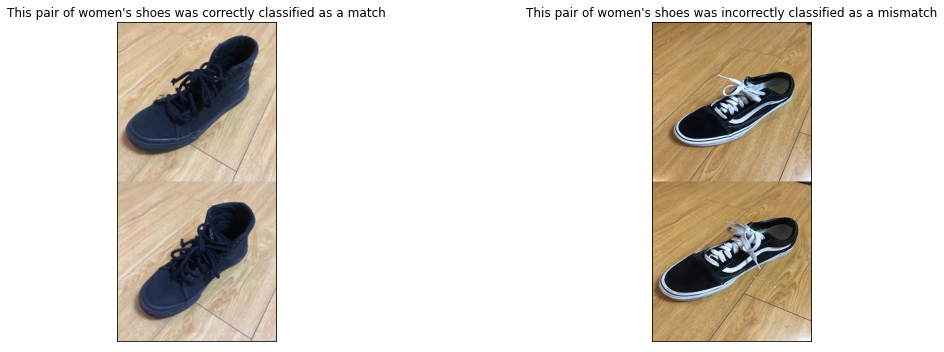

In [36]:
test_womens_same = generate_same_pair(test_w_data)
preds = np.argmax(channel_cnn(torch.Tensor(test_womens_same).permute(0, 3, 1, 2)).detach().numpy(), axis=1)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
fig.tight_layout(pad=1.0)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

for i in range(len(preds)):
  correct = 0
  incorrect = 0

  if preds[i] == 0 and incorrect == 0:
    #print('This pair of women\'s shoes was incorrectly classified as a mismatch')
    ax[1].imshow(test_womens_same[i] + 0.5)
    ax[1].set_title('This pair of women\'s shoes was incorrectly classified as a mismatch')
    incorrect += 1

  elif preds[i] == 1 and correct == 0:
    ax[0].imshow(test_womens_same[i] + 0.5)
    ax[0].set_title('This pair of women\'s shoes was correctly classified as a match')
    correct += 1

  elif correct == 1 and incorrect == 1:
    break

  elif correct == 1 and i == len(preds) - 1:
    print('There are no incorrect predictions')
    
  elif incorrect == 1 and i == len(preds) - 1:
    print('There are no correct predictions')